In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os



import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance

from tqdm import tqdm_notebook

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


# import json

from IPython.display import HTML


import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv('../data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('../data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('../data/test_features.csv', index_col='match_id_hash')

In [3]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
train['radiant_win'] = target['radiant_win']

Fold 0 started at Sun Oct 13 05:58:09 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.871381	valid_1's auc: 0.803698
[2000]	training's auc: 0.916242	valid_1's auc: 0.811218
[3000]	training's auc: 0.947828	valid_1's auc: 0.814658
[4000]	training's auc: 0.968347	valid_1's auc: 0.81622
[5000]	training's auc: 0.981699	valid_1's auc: 0.816999
Early stopping, best iteration is:
[5275]	training's auc: 0.984292	valid_1's auc: 0.817243
Fold 1 started at Sun Oct 13 05:58:30 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.87377	valid_1's auc: 0.791028
[2000]	training's auc: 0.917998	valid_1's auc: 0.79711
[3000]	training's auc: 0.949091	valid_1's auc: 0.800414
[4000]	training's auc: 0.969188	valid_1's auc: 0.802357
[5000]	training's auc: 0.982289	valid_1's auc: 0.803342
[6000]	training's auc: 0.990197	valid_1's auc: 0.804354
Early stopping, best iteration is:
[6090]	training's auc: 0.990783	valid_1's auc: 0.80

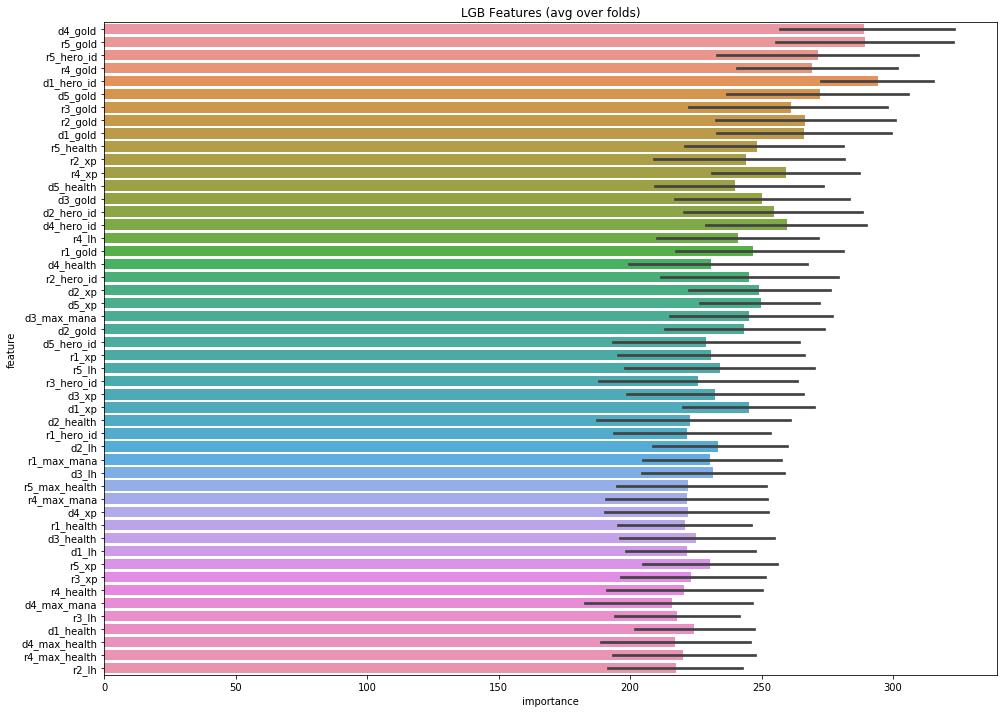

In [6]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [7]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)
    test['mean_' + c + '_ratio'] = test['r_mean_' + c] /  test['d_mean_' + c]

Fold 0 started at Sun Oct 13 06:00:05 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.885164	valid_1's auc: 0.82639
[2000]	training's auc: 0.932224	valid_1's auc: 0.828727
Early stopping, best iteration is:
[2665]	training's auc: 0.954337	valid_1's auc: 0.829311
Fold 1 started at Sun Oct 13 06:00:18 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.887294	valid_1's auc: 0.814078
[2000]	training's auc: 0.934039	valid_1's auc: 0.816665
[3000]	training's auc: 0.964726	valid_1's auc: 0.818082
Early stopping, best iteration is:
[3667]	training's auc: 0.97843	valid_1's auc: 0.818353
Fold 2 started at Sun Oct 13 06:00:35 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.884774	valid_1's auc: 0.829687
[2000]	training's auc: 0.932347	valid_1's auc: 0.831208
Early stopping, best iteration is:
[1879]	training's auc: 0.927593	valid_1's auc: 0.831332
Fold 3 started at Sun 

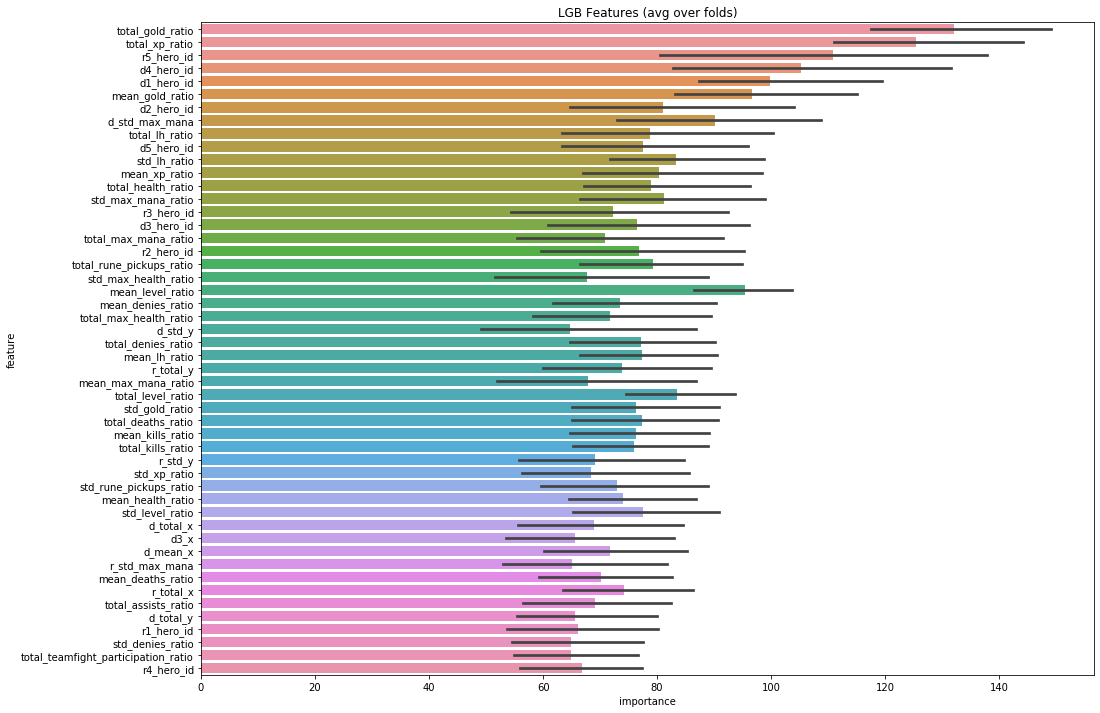

In [8]:
X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [9]:
new_cols = train.columns[-207:]

In [10]:
train[new_cols].head()

,r_total_kills,d_total_kills,total_kills_ratio,r_std_kills,d_std_kills,std_kills_ratio,r_mean_kills,d_mean_kills,mean_kills_ratio,r_total_deaths,d_total_deaths,total_deaths_ratio,r_std_deaths,d_std_deaths,std_deaths_ratio,r_mean_deaths,d_mean_deaths,mean_deaths_ratio,r_total_assists,d_total_assists,total_assists_ratio,r_std_assists,d_std_assists,std_assists_ratio,r_mean_assists,d_mean_assists,mean_assists_ratio,r_total_denies,d_total_denies,total_denies_ratio,r_std_denies,d_std_denies,std_denies_ratio,r_mean_denies,d_mean_denies,mean_denies_ratio,r_total_gold,d_total_gold,total_gold_ratio,r_std_gold,d_std_gold,std_gold_ratio,r_mean_gold,d_mean_gold,mean_gold_ratio,r_total_lh,d_total_lh,total_lh_ratio,r_std_lh,d_std_lh,std_lh_ratio,r_mean_lh,d_mean_lh,mean_lh_ratio,r_total_xp,d_total_xp,total_xp_ratio,r_std_xp,d_std_xp,std_xp_ratio,r_mean_xp,d_mean_xp,mean_xp_ratio,r_total_health,d_total_health,total_health_ratio,r_std_health,d_std_health,std_health_ratio,r_mean_health,d_mean_health,mean_health_ratio,r_total_max_health,d_total_max_health,total_max_health_ratio,r_std_max_health,d_std_max_health,std_max_health_ratio,r_mean_max_health,d_mean_max_health,mean_max_health_ratio,r_total_max_mana,d_total_max_mana,total_max_mana_ratio,r_std_max_mana,d_std_max_mana,std_max_mana_ratio,r_mean_max_mana,d_mean_max_mana,mean_max_mana_ratio,r_total_level,d_total_level,total_level_ratio,r_std_level,d_std_level,std_level_ratio,r_mean_level,d_mean_level,mean_level_ratio,r_total_x,d_total_x,total_x_ratio,r_std_x,d_std_x,std_x_ratio,r_mean_x,d_mean_x,mean_x_ratio,r_total_y,d_total_y,total_y_ratio,r_std_y,d_std_y,std_y_ratio,r_mean_y,d_mean_y,mean_y_ratio,r_total_stuns,d_total_stuns,total_stuns_ratio,r_std_stuns,d_std_stuns,std_stuns_ratio,r_mean_stuns,d_mean_stuns,mean_stuns_ratio,r_total_creeps_stacked,d_total_creeps_stacked,total_creeps_stacked_ratio,r_std_creeps_stacked,d_std_creeps_stacked,std_creeps_stacked_ratio,r_mean_creeps_stacked,d_mean_creeps_stacked,mean_creeps_stacked_ratio,r_total_camps_stacked,d_total_camps_stacked,total_camps_stacked_ratio,r_std_camps_stacked,d_std_camps_stacked,std_camps_stacked_ratio,r_mean_camps_stacked,d_mean_camps_stacked,mean_camps_stacked_ratio,r_total_rune_pickups,d_total_rune_pickups,total_rune_pickups_ratio,r_std_rune_pickups,d_std_rune_pickups,std_rune_pickups_ratio,r_mean_rune_pickups,d_mean_rune_pickups,mean_rune_pickups_ratio,r_total_firstblood_claimed,d_total_firstblood_claimed,total_firstblood_claimed_ratio,r_std_firstblood_claimed,d_std_firstblood_claimed,std_firstblood_claimed_ratio,r_mean_firstblood_claimed,d_mean_firstblood_claimed,mean_firstblood_claimed_ratio,r_total_teamfight_participation,d_total_teamfight_participation,total_teamfight_participation_ratio,r_std_teamfight_participation,d_std_teamfight_participation,std_teamfight_participation_ratio,r_mean_teamfight_participation,d_mean_teamfight_participation,mean_teamfight_participation_ratio,r_total_towers_killed,d_total_towers_killed,total_towers_killed_ratio,r_std_towers_killed,d_std_towers_killed,std_towers_killed_ratio,r_mean_towers_killed,d_mean_towers_killed,mean_towers_killed_ratio,r_total_roshans_killed,d_total_roshans_killed,total_roshans_killed_ratio,r_std_roshans_killed,d_std_roshans_killed,std_roshans_killed_ratio,r_mean_roshans_killed,d_mean_roshans_killed,mean_roshans_killed_ratio,r_total_obs_placed,d_total_obs_placed,total_obs_placed_ratio,r_std_obs_placed,d_std_obs_placed,std_obs_placed_ratio,r_mean_obs_placed,d_mean_obs_placed,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,1,0.000000,0.000000,0.447214,0.000000,0.0,0.2,0.000000,1

In [11]:
test[new_cols].head()

,r_total_kills,d_total_kills,total_kills_ratio,r_std_kills,d_std_kills,std_kills_ratio,r_mean_kills,d_mean_kills,mean_kills_ratio,r_total_deaths,d_total_deaths,total_deaths_ratio,r_std_deaths,d_std_deaths,std_deaths_ratio,r_mean_deaths,d_mean_deaths,mean_deaths_ratio,r_total_assists,d_total_assists,total_assists_ratio,r_std_assists,d_std_assists,std_assists_ratio,r_mean_assists,d_mean_assists,mean_assists_ratio,r_total_denies,d_total_denies,total_denies_ratio,r_std_denies,d_std_denies,std_denies_ratio,r_mean_denies,d_mean_denies,mean_denies_ratio,r_total_gold,d_total_gold,total_gold_ratio,r_std_gold,d_std_gold,std_gold_ratio,r_mean_gold,d_mean_gold,mean_gold_ratio,r_total_lh,d_total_lh,total_lh_ratio,r_std_lh,d_std_lh,std_lh_ratio,r_mean_lh,d_mean_lh,mean_lh_ratio,r_total_xp,d_total_xp,total_xp_ratio,r_std_xp,d_std_xp,std_xp_ratio,r_mean_xp,d_mean_xp,mean_xp_ratio,r_total_health,d_total_health,total_health_ratio,r_std_health,d_std_health,std_health_ratio,r_mean_health,d_mean_health,mean_health_ratio,r_total_max_health,d_total_max_health,total_max_health_ratio,r_std_max_health,d_std_max_health,std_max_health_ratio,r_mean_max_health,d_mean_max_health,mean_max_health_ratio,r_total_max_mana,d_total_max_mana,total_max_mana_ratio,r_std_max_mana,d_std_max_mana,std_max_mana_ratio,r_mean_max_mana,d_mean_max_mana,mean_max_mana_ratio,r_total_level,d_total_level,total_level_ratio,r_std_level,d_std_level,std_level_ratio,r_mean_level,d_mean_level,mean_level_ratio,r_total_x,d_total_x,total_x_ratio,r_std_x,d_std_x,std_x_ratio,r_mean_x,d_mean_x,mean_x_ratio,r_total_y,d_total_y,total_y_ratio,r_std_y,d_std_y,std_y_ratio,r_mean_y,d_mean_y,mean_y_ratio,r_total_stuns,d_total_stuns,total_stuns_ratio,r_std_stuns,d_std_stuns,std_stuns_ratio,r_mean_stuns,d_mean_stuns,mean_stuns_ratio,r_total_creeps_stacked,d_total_creeps_stacked,total_creeps_stacked_ratio,r_std_creeps_stacked,d_std_creeps_stacked,std_creeps_stacked_ratio,r_mean_creeps_stacked,d_mean_creeps_stacked,mean_creeps_stacked_ratio,r_total_camps_stacked,d_total_camps_stacked,total_camps_stacked_ratio,r_std_camps_stacked,d_std_camps_stacked,std_camps_stacked_ratio,r_mean_camps_stacked,d_mean_camps_stacked,mean_camps_stacked_ratio,r_total_rune_pickups,d_total_rune_pickups,total_rune_pickups_ratio,r_std_rune_pickups,d_std_rune_pickups,std_rune_pickups_ratio,r_mean_rune_pickups,d_mean_rune_pickups,mean_rune_pickups_ratio,r_total_firstblood_claimed,d_total_firstblood_claimed,total_firstblood_claimed_ratio,r_std_firstblood_claimed,d_std_firstblood_claimed,std_firstblood_claimed_ratio,r_mean_firstblood_claimed,d_mean_firstblood_claimed,mean_firstblood_claimed_ratio,r_total_teamfight_participation,d_total_teamfight_participation,total_teamfight_participation_ratio,r_std_teamfight_participation,d_std_teamfight_participation,std_teamfight_participation_ratio,r_mean_teamfight_participation,d_mean_teamfight_participation,mean_teamfight_participation_ratio,r_total_towers_killed,d_total_towers_killed,total_towers_killed_ratio,r_std_towers_killed,d_std_towers_killed,std_towers_killed_ratio,r_mean_towers_killed,d_mean_towers_killed,mean_towers_killed_ratio,r_total_roshans_killed,d_total_roshans_killed,total_roshans_killed_ratio,r_std_roshans_killed,d_std_roshans_killed,std_roshans_killed_ratio,r_mean_roshans_killed,d_mean_roshans_killed,mean_roshans_killed_ratio,r_total_obs_placed,d_total_obs_placed,total_obs_placed_ratio,r_std_obs_placed,d_std_obs_placed,std_obs_placed_ratio,r_mean_obs_placed,d_mean_obs_placed,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30cc2d778dca82f2edb568ce9b585caa,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN,0,0,NaN,0.000000

In [17]:
FE = pd.concat([train[new_cols], test[new_cols]])

In [18]:
FE.to_csv('fe.csv')

In [19]:
FE.shape

(49675, 207)

In [15]:
X.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,r_total_kills,d_total_kills,total_kills_ratio,r_std_kills,d_std_kills,std_kills_ratio,r_mean_kills,d_mean_kills,mean_kills_ratio,r_total_deaths,d_total_deaths,total_deaths_ratio,r_std_deaths,d_std_deaths,std_deaths_ratio,r_mean_deaths,d_mean_deaths,mean_deaths_ratio,r_total_assists,d_total_assists,total_assists_ratio,r_std_assists,d_std_assists,std_assists_ratio,r_mean_assists,d_mean_assists,mean_assists_ratio,r_total_denies,d_total_denies,total_denies_ratio,r_std_denies,d_std_denies,std_denies_ratio,r_mean_denies,d_mean_denies,mean_denies_ratio,r_total_gold,d_total_gold,total_gold_ratio,r_std_gold,d_std_gold,std_gold_ratio,r_mean_gold,d_mean_gold,mean_gold_ratio,r_total_lh,d_total_lh,total_lh_ratio,r_std_lh,d_std_lh,std_lh_ratio,r_mean_lh,d_mean_lh,mean_lh_ratio,r_total_xp,d_total_xp,total_xp_ratio,r_std_xp,d_std_xp,std_xp_ratio,r_mean_xp,d_mean_xp,mean_xp_ratio,r_total_health,d_total_health,total_health_ratio,r_std_health,d_std_health,std_health_ra

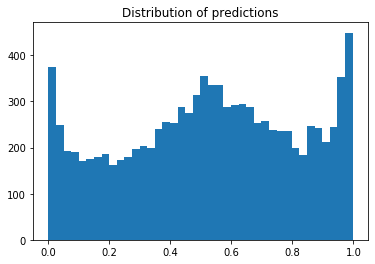

In [16]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');